In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
from sklearn.linear_model import LinearRegression
from datetime import datetime
from matplotlib.dates import date2num

In [2]:
# Import grade data
df_grade = pd.read_csv("Data/2020-12-23T0914_Grades-ECO202Y5_Y_All_Sections.csv")
df_grade = df_grade.set_index('ID')

# Import data to match grade and zoom
df_match = pd.read_excel("Data/ID_match.xlsx", sheet_name = "ID and Email")
df_match = df_match.set_index('Email')

In [3]:
# Calculate Term Test 1 and 2 raw score
df_grade['Test 1 - v1'] = df_grade['1357 - Term Test 1 - Part 1 (406688)'] + df_grade['1357 - Term Test 1 - Part 2 (457963)']
df_grade['Test 1 - v2'] = df_grade['2468 - Term Test 1 - Part 1 (457964)'] + df_grade['2468 - Term Test 1 - Part 2 (457965)']

df_grade['Test 1'] = df_grade[['Test 1 - v1', 'Test 1 - v2']].max(axis =1)

df_grade['Test 2 - 12'] = df_grade['12 - Term Test 2 - Part 1 (475535)'] + df_grade['12 - Term Test 2 - Part 2 (475539)']
df_grade['Test 2 - 34'] = df_grade['34 - Term Test 2 - Part 1 (475536)'] + df_grade['34 - Term Test 2 - Part 2 (475540)']
df_grade['Test 2 - v1'] = df_grade[['Test 2 - 12', 'Test 2 - 34']].max(axis =1)

df_grade['Test 2 - 56'] = df_grade['56 - Term Test 2 - Part 1 (475537)'] + df_grade['56 - Term Test 2 - Part 2 (475541)']
df_grade['Test 2 - 78'] = df_grade['78 - Term Test 2 - Part 1 (475538)'] + df_grade['78 - Term Test 2 - Part 2 (475542)']
df_grade['Test 2 - v2'] = df_grade[['Test 2 - 56', 'Test 2 - 78']].max(axis =1)

df_grade['Test 2'] = df_grade[['Test 2 - v1', 'Test 2 - v2']].max(axis =1)

Text(0.5, 0, 'Test Score')

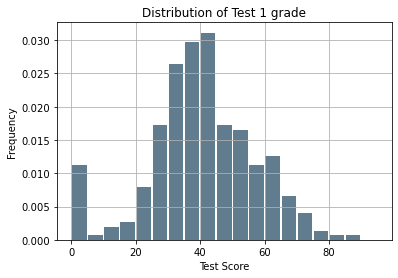

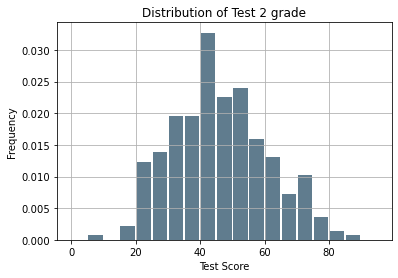

In [306]:
# Histogram of grade
plt.figure()
df_grade['Test 1'].plot.hist(density= True, grid=True, bins=np.arange(0,100,5), rwidth=0.9, color='#607c8e')
plt.title('Distribution of Test 1 grade')
plt.xlabel('Test Score')

plt.figure()
df_grade['Test 2'].plot.hist(density= True, grid=True, bins=np.arange(0,100,5), rwidth=0.9, color='#607c8e')
plt.title('Distribution of Test 2 grade')
plt.xlabel('Test Score')

In [50]:
# Merge all Zoom lectures
zoom_files = ['Sept16.csv', 'Sept23.csv', 'Sept30.csv', 'Oct7.csv', 'Oct28.csv', 'Nov4.csv', 'Nov11.csv', 'Nov18.csv', 'Nov25.csv']
df_zoom = pd.read_csv('Data/' + zoom_files[0], parse_dates=['Date(UTC)'])
df_zoom['Lecture'] = 1

for i in range(1, len(zoom_files)):
    data = pd.read_csv('Data/' + zoom_files[i], parse_dates=['Date(UTC)'])
    data['Lecture'] = i + 1
    df_zoom = df_zoom.append(data)

# Match Email with ID in Grade File
df_zoom = df_zoom.dropna(subset =['Email'])
df_zoom.index = np.arange(0, len(df_zoom))

df_zoom['ID'] = df_zoom['Email']

for i in range(0, len(df_zoom)):
    if df_zoom['Email'][i] in list(df_match.index):
        df_zoom['ID'][i] = df_match['ID'][df_zoom['Email'][i]]
    else:
        df_zoom['ID'][i] = float('nan')

# Drop unidentified people
df_zoom = df_zoom.dropna(subset =['ID'])


Text(0, 0.5, 'Counts')

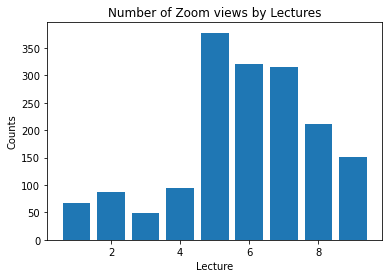

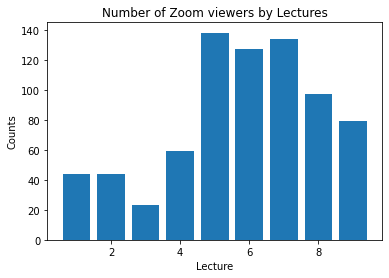

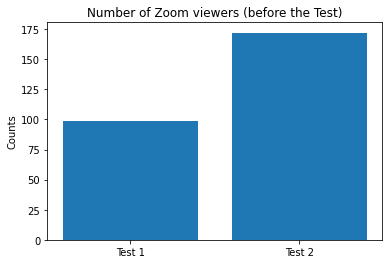

In [51]:
# Plot number of views and viewers by lecture
# Note: Lecture 4 is the last lecture before Term Test 1
views = [0] * 9
viewers = [0] * 9
lecture = [0] * 9

for i in range(0,9):
    lecture[i] = i + 1
    views[i] = len(df_zoom[df_zoom['Lecture'] == i + 1])
    viewers[i] = len(df_zoom['Email'][df_zoom['Lecture'] == i + 1].unique())

plt.figure()
plt.bar(lecture, views)
plt.title('Number of Zoom views by Lectures')
plt.xlabel('Lecture')
plt.ylabel('Counts')

plt.figure()
plt.bar(lecture, viewers)
plt.title('Number of Zoom viewers by Lectures')
plt.xlabel('Lecture')
plt.ylabel('Counts')

# Number of viewers for Test 1 and Test 2
viewers_test = [0,0]
viewers_test[0] = len(df_zoom['Email'][df_zoom['Lecture'] < 5].unique())
viewers_test[1] = len(df_zoom['Email'][df_zoom['Lecture'] >= 5].unique())

plt.figure()
plt.bar(['Test 1', 'Test 2'], viewers_test)
plt.title('Number of Zoom viewers (before the Test)')
plt.ylabel('Counts')

In [144]:
# Count number of views/viewers per day for each lecture video
date_list = df_zoom['Date(UTC)'].unique()
lecture_list = list(range(1,11))            # Lecture from 1 to 9. Lecture 10 is the Total of all lectures

df_bydate = pd.DataFrame(index = pd.MultiIndex.from_product([lecture_list, date_list], names = [ 'Lecture', 'date']), columns = ['views', 'viewers'])

for lec in list(range(1,11)):
    for t in date_list:
        if lec < 10:
            x = df_zoom[df_zoom['Lecture'] == lec]
            df_bydate['views'][lec, t] = len(x[x['Date(UTC)'] == t])
            df_bydate['viewers'][lec, t] = len(x['Email'][x['Date(UTC)'] == t].unique())
        else:
            df_bydate['views'][lec, t] = len(df_zoom[df_zoom['Date(UTC)'] == t])
            df_bydate['viewers'][lec, t] = len(df_zoom['Email'][df_zoom['Date(UTC)'] == t].unique())

Text(0.5, 1.0, 'Total Number of Views and Viewers over time')

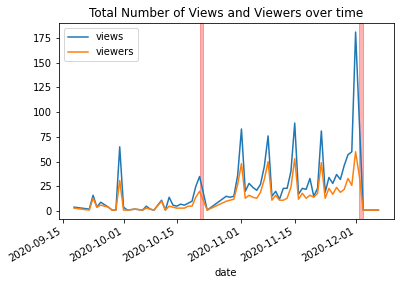

In [145]:
# Plot Number of Views and Viewers over time
# The red lines are date of Exams
df_bydate.loc[10].plot()
plt.axvspan(date2num(datetime(2020,10,21)), date2num(datetime(2020,10,22)), label="Test 1 Date",color="red", alpha=0.3)
plt.axvspan(date2num(datetime(2020,12,2)), date2num(datetime(2020,12,3)), label="Test 2 Date",color="red", alpha=0.3)
plt.title('Total Number of Views and Viewers over time')

Text(0.5, 1.0, 'Total Number of Views and Viewers over time')

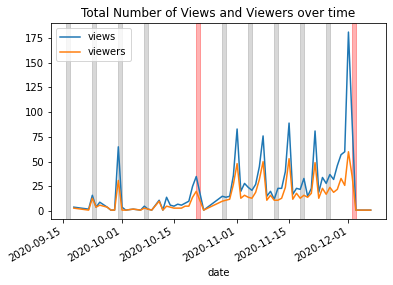

In [173]:
# Plot Number of Views and Viewers over time
# The gray line represents the date of Lectures, the red one is date of Exams
df_bydate.loc[10].plot()

lecture_dates = {}
lecture_dates[1] = date2num(datetime(2020,9,16))
lecture_dates[2] = date2num(datetime(2020,9,23))
lecture_dates[3] = date2num(datetime(2020,9,30))
lecture_dates[4] = date2num(datetime(2020,10,7))
lecture_dates[5] = date2num(datetime(2020,10,28))
lecture_dates[6] = date2num(datetime(2020,11,4))
lecture_dates[7] = date2num(datetime(2020,11,11))
lecture_dates[8] = date2num(datetime(2020,11,18))
lecture_dates[9] = date2num(datetime(2020,11,25))

plt.axvspan(date2num(datetime(2020,9,16)), date2num(datetime(2020,9,17)), label="Lecture 1 Date",color="gray", alpha=0.3)
plt.axvspan(date2num(datetime(2020,9,23)), date2num(datetime(2020,9,24)), label="Lecture 2 Date",color="gray", alpha=0.3)
plt.axvspan(date2num(datetime(2020,9,30)), date2num(datetime(2020,10,1)), label="Lecture 3 Date",color="gray", alpha=0.3)
plt.axvspan(date2num(datetime(2020,10,7)), date2num(datetime(2020,10,8)), label="Lecture 4 Date",color="gray", alpha=0.3)
plt.axvspan(date2num(datetime(2020,10,28)), date2num(datetime(2020,10,29)), label="Lecture 5 Date",color="gray", alpha=0.3)
plt.axvspan(date2num(datetime(2020,11,4)), date2num(datetime(2020,11,5)), label="Lecture 6 Date",color="gray", alpha=0.3)
plt.axvspan(date2num(datetime(2020,11,11)), date2num(datetime(2020,11,12)), label="Lecture 7 Date",color="gray", alpha=0.3)
plt.axvspan(date2num(datetime(2020,11,18)), date2num(datetime(2020,11,19)), label="Lecture 8 Date",color="gray", alpha=0.3)
plt.axvspan(date2num(datetime(2020,11,25)), date2num(datetime(2020,11,26)), label="Lecture 9 Date",color="gray", alpha=0.3)
plt.axvspan(date2num(datetime(2020,10,21)), date2num(datetime(2020,10,22)), label="Test 1 Date",color="red", alpha=0.3)
plt.axvspan(date2num(datetime(2020,12,2)), date2num(datetime(2020,12,3)), label="Test 2 Date",color="red", alpha=0.3)

plt.title('Total Number of Views and Viewers over time')

In [171]:
date2num(datetime(2020,9,17))

737685.0

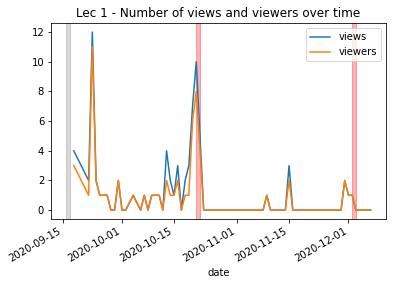

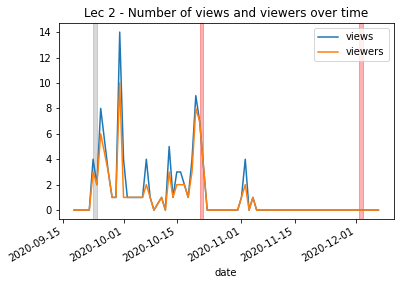

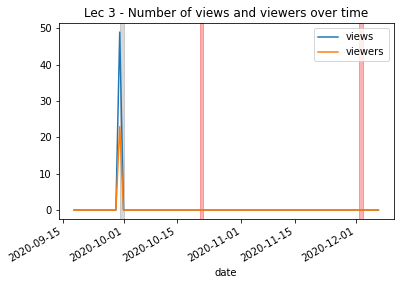

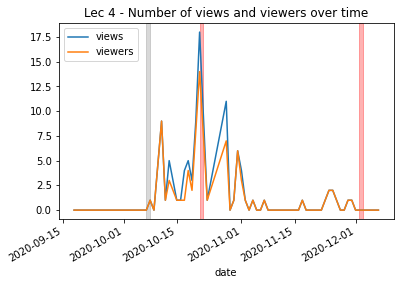

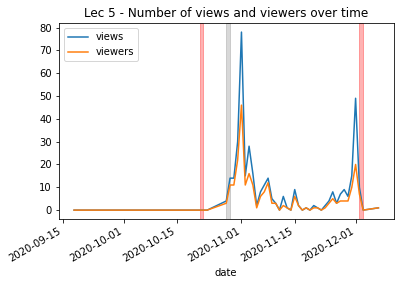

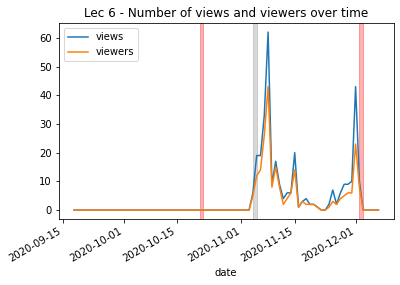

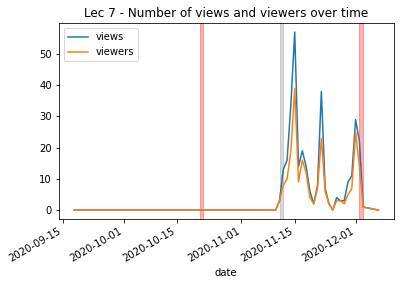

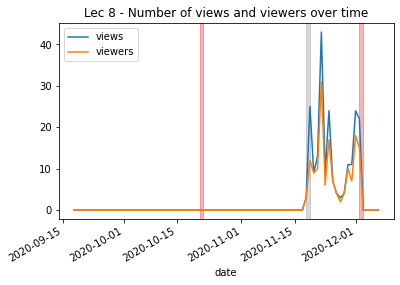

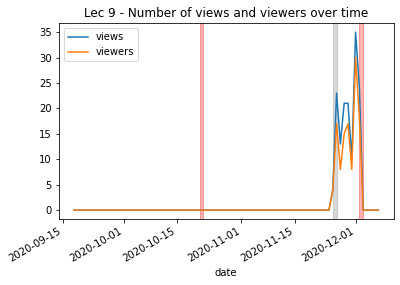

In [176]:
# Plot number of Views and Views by Lectures
# Red lines are Exam Date, Grey line is the date of the lecture
for i in range(1,10):
    df_bydate.loc[i].plot()
    plt.axvspan(date2num(datetime(2020,10,21)), date2num(datetime(2020,10,22)), label="Test 1 Date",color="red", alpha=0.3)
    plt.axvspan(date2num(datetime(2020,12,2)), date2num(datetime(2020,12,3)), label="Test 2 Date",color="red", alpha=0.3)
    plt.axvspan(lecture_dates[i], lecture_dates[i]+1, color="gray", alpha=0.3)
    plt.title('Lec ' + str(i) + ' - Number of views and viewers over time')

In [167]:
# Identify students who view videos
df_grade['Test 1 - Watch'] = 0
df_grade['Test 2 - Watch'] = 0

for i in df_zoom['ID'][df_zoom['Lecture'] < 5]:
    df_grade['Test 1 - Watch'][i] = 1

for i in df_zoom['ID'][df_zoom['Lecture'] >= 5]:
    df_grade['Test 2 - Watch'][i] = 1

# Distribution of 4 groups: 1 - Never watch, 2- Watch 1 but not 2, 3 - Watch 2 but not 1, 4 - Watch both
no_students = {}
no_students['Type 1 - Never Watch'] = len(df_grade[df_grade['Test 1 - Watch'] == 0][df_grade['Test 2 - Watch'] == 0])
no_students['Type 2 - Watch 1 but not 2'] = len(df_grade[df_grade['Test 1 - Watch'] == 1][df_grade['Test 2 - Watch'] == 0])
no_students['Type 3 - Watch 2 but not 1'] = len(df_grade[df_grade['Test 1 - Watch'] == 0][df_grade['Test 2 - Watch'] == 1])
no_students['Type 4 - Watch Both'] = len(df_grade[df_grade['Test 1 - Watch'] == 1][df_grade['Test 2 - Watch'] == 1])

no_students

{'Type 1 - Never Watch': 133,
 'Type 2 - Watch 1 but not 2': 14,
 'Type 3 - Watch 2 but not 1': 86,
 'Type 4 - Watch Both': 84}

Text(0.5, 0, 'Test Score')

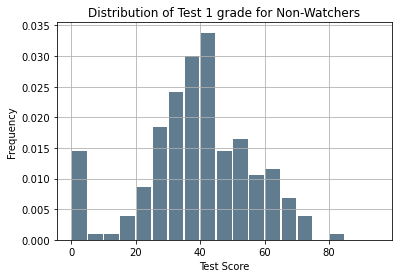

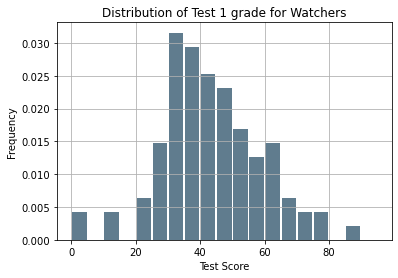

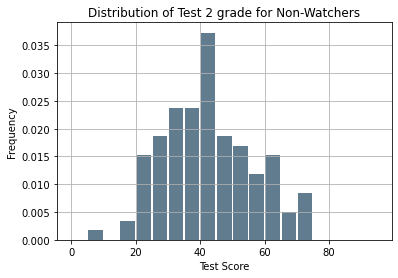

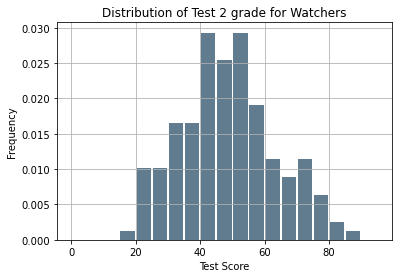

In [151]:
# Historgram of Grade

# Test 1
# Not watch group
plt.figure()
df_grade['Test 1'][df_grade['Test 1 - Watch'] == 0].plot.hist(density=True, grid=True, bins=np.arange(0,100,5), rwidth=0.9, color='#607c8e')
plt.title('Distribution of Test 1 grade for Non-Watchers')
plt.xlabel('Test Score')

# Watch group
plt.figure()
df_grade['Test 1'][df_grade['Test 1 - Watch'] == 1].plot.hist(density=True, grid=True, bins=np.arange(0,100,5), rwidth=0.9, color='#607c8e')
plt.title('Distribution of Test 1 grade for Watchers')
plt.xlabel('Test Score')

#####################################################################################################################
# Test 2
# Not watch group
plt.figure()
df_grade['Test 2'][df_grade['Test 2 - Watch'] == 0].plot.hist(density=True, grid=True, bins=np.arange(0,100,5), rwidth=0.9, color='#607c8e')
plt.title('Distribution of Test 2 grade for Non-Watchers')
plt.xlabel('Test Score')

# Watch group
plt.figure()
df_grade['Test 2'][df_grade['Test 2 - Watch'] == 1].plot.hist(density=True, grid=True, bins=np.arange(0,100,5), rwidth=0.9, color='#607c8e')
plt.title('Distribution of Test 2 grade for Watchers')
plt.xlabel('Test Score')

In [305]:
# Effects of watching videos on Test 1 grade
import statsmodels.api as sm
data = df_grade[['Test 1', 'Test 1 - Watch']].dropna()
y = data['Test 1']
x = sm.add_constant(data['Test 1 - Watch'])

model = sm.OLS(y, x).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Test 1   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     4.128
Date:                Mon, 04 Jan 2021   Prob (F-statistic):             0.0431
Time:                        00:31:53   Log-Likelihood:                -1272.8
No. Observations:                 302   AIC:                             2550.
Df Residuals:                     300   BIC:                             2557.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             38.7899      1.142     33.969      0.000      36.543      41.037
Test 1 - Watch     4.1365      2.036      2.032      0.043       0.130       8.143
==============================================================================
Omnibus:                        5.782   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                5.779
Skew:                          -0.258   Prob(JB):                       0.0556
Kurtosis:                       3.440   Cond. No.                         2.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [304]:
# Effects of watching videos on Test 2 grade
import statsmodels.api as sm
data = df_grade[['Test 2', 'Test 2 - Watch']].dropna()
y = data['Test 2']
x = sm.add_constant(data['Test 2 - Watch'])

model = sm.OLS(y, x).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Test 2   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     12.16
Date:                Mon, 04 Jan 2021   Prob (F-statistic):           0.000567
Time:                        00:31:51   Log-Likelihood:                -1132.4
No. Observations:                 276   AIC:                             2269.
Df Residuals:                     274   BIC:                             2276.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             42.4703      1.353     31.397      0.000      39.807      45.133
Test 2 - Watch     6.2354      1.788      3.488      0.001       2.716       9.755
==============================================================================
Omnibus:                        5.013   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                5.101
Skew:                           0.312   Prob(JB):                       0.0780
Kurtosis:                       2.768   Cond. No.                         2.82
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [359]:
# Study the impact of watching videos for students who didn't watch before Test 1 but watched in Test 2
# Dif-in-Dif: Select group of students who didn't watch in Test 1
data = df_grade[['Test 1', 'Test 2', 'Test 2 - Watch']][df_grade['Test 1 - Watch'] == 0].dropna()
data = data.rename(columns = {'Test 2 - Watch': 'Treatment1'})
data['Treatment2'] = data['Treatment1']
data['ID'] = data.index
data = pd.wide_to_long(data, stubnames = ['Test ', 'Treatment'], i = ['ID'], j = 'Test')
data = data.rename(columns={'Test ':'Grade'})

data['ID'] = data.index.get_level_values(0)
data['Test'] = data.index.get_level_values(1) - 1
data['treat*test'] = data['Treatment']*data['Test']


In [360]:
# Effects of watching videos on Test 2 grade:
# Insignificant effect: coefficient of treat*test variable
import statsmodels.api as sm
y = data['Grade']
x = sm.add_constant(data[['Treatment', 'Test', 'treat*test']])

model = sm.OLS(y, x).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Grade   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     5.110
Date:                Mon, 04 Jan 2021   Prob (F-statistic):            0.00179
Time:                        01:06:36   Log-Likelihood:                -1488.1
No. Observations:                 364   AIC:                             2984.
Df Residuals:                     360   BIC:                             3000.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.5896      1.409     28.093      0.000      36.818      42.361
Treatment      3.9893      2.181      1.829      0.068      -0.299       8.278
Test           3.3726      1.993      1.692      0.091      -0.547       7.292
treat*test     1.1537      3.084      0.374      0.709      -4.911       7.219
==============================================================================
Omnibus:                        3.191   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.203   Jarque-Bera (JB):                2.918
Skew:                           0.203   Prob(JB):                        0.232
Kurtosis:                       3.167   Cond. No.                         6.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""